In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os, sys
sys.path.append(os.path.join("..//"))
## pcp plotting script from https://github.com/gregornickel/pcp/tree/main MIT License
import pcp.plot

import joblib
import optuna 

import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import Rectangle

import scipy.stats as st
from scipy.stats import bootstrap


c:\Users\maddy\anaconda3\envs\bgdlenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Explore the Results of the Hyperparameter Optimisation

Load the data

In [2]:
dir_Hop = r'..//data//HOP_HPO_31_10_2024_17_42_24'
dir_IA = r'..//data//IA_HPO_31_10_2024_18_31_22'
dir_WTA = r'..//data//WTA_HPO_31_10_2024_18_31_22'
dir_DNF = r'..//data//WTA_HPO_31_10_2024_18_31_22'
dir_SA = r'..//data//SA_HPO_31_10_2024_22_31_55'
dir_SAD = r'..//data//SAD_HPO_31_10_2024_23_27_07'
dir_DA = r'..//data//DA_HPO_04_11_2024_17_02_31'
dir_Hop = r'..//data//HOP_HPO_11_11_2024_13_39_52'
dir_IA = r'..//data//IA_HPO_11_11_2024_14_26_44'
dir_WTA = r'..//data//WTA_HPO_11_11_2024_22_14_49'
dir_DNF = r'..//data//DNF_HPO_15_11_2024_14_05_47'
dir_SA = r'..//data//SA_HPO_11_11_2024_18_15_39'
dir_SAD = r'..//data//SAD_HPO_11_11_2024_21_51_15'
dir_DA = r'..//data//DA_HPO_12_11_2024_14_43_46'

Load the optuna pickle files containing the optuna data

In [3]:
study_Hop = joblib.load(rf'{dir_Hop}\optuna.pkl')
study_IA = joblib.load(rf'{dir_IA}\optuna.pkl')
study_WTA = joblib.load(rf'{dir_WTA}\optuna.pkl')
study_DNF = joblib.load(rf'{dir_DNF}\optuna.pkl')
study_SA = joblib.load(rf'{dir_SA}\optuna.pkl')
study_SAD = joblib.load(rf'{dir_SAD}\optuna.pkl')
study_DA = joblib.load(rf'{dir_DA}\optuna.pkl')

STUDYS = {"Hopfield": study_Hop , 
          "Accumulator":study_IA, 
          "WTA":study_WTA, 
          "DNF": study_DNF,
          "Shallow Attractor":study_SA, 
          "Shallow Attractor Place":study_SAD,
          "Deep Attractor":study_DA,}
          
COLOURS = {"Hopfield": '#6a3009',
          "Accumulator": '#d46011', 
          "WTA": '#b04f0e', 
          "DNF": '#e97c4c',
          "Shallow Attractor": '#076152', 
          "Shallow Attractor Place": '#0b937d',
          "Deep Attractor": '#0fc9aa',}

pareto_front = {}
for name in STUDYS:
    nums = []
    print(name)
    for i in range(len(STUDYS[name].best_trials)):
        print(f'{STUDYS[name].best_trials[i]}')
        nums.append(STUDYS[name].best_trials[i].number)
    pareto_front.update({name: nums})
    print()

Hopfield
FrozenTrial(number=5, state=TrialState.COMPLETE, values=[1.5650706054360615, -0.731721337836618], datetime_start=datetime.datetime(2024, 11, 11, 13, 42, 26, 419067), datetime_complete=datetime.datetime(2024, 11, 11, 13, 43, 11, 400714), params={'inp_weight': 1.7058210991201754e-08, 'temp': 8.792577324766874, 'ens_neurons': 5000}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'inp_weight': FloatDistribution(high=2.0, log=True, low=1e-09, step=None), 'temp': FloatDistribution(high=10.0, log=False, low=0.1, step=None), 'ens_neurons': CategoricalDistribution(choices=(1000, 2000, 5000))}, trial_id=5, value=None)
FrozenTrial(number=30, state=TrialState.COMPLETE, values=[0.225512749085279, -0.6184449347471808], datetime_start=datetime.datetime(2024, 11, 11, 13, 53, 41, 378283), datetime_complete=datetime.datetime(2024, 11, 11, 13, 54, 2, 969893), params={'inp_weight': 0.2083263717359317, 'temp': 2.8615766425949687, 'ens_neurons': 2000}, user_attrs={}, system_

Optuna gives us the trials at the pareto-front of the performance space. 

Let's plot the pareto front to see if there's a stand-out winner.

In [4]:
def get_data(folder):
    allData=[]
    i=0
    for filename in os.listdir(folder):
        if '.npz' in filename:
            filepath = os.path.join(folder, filename)
            arr=np.load(filepath, allow_pickle=True)
            
            vals=[]
            if i==0:
                header = arr.files
                df = pd.DataFrame(header)
            
            for item in arr.files:
                vals.append(arr[item])
            
            allData.append(vals)
            i+=1
    return allData, header
    
data_hop, header_hop = get_data(dir_Hop)   
df_hop = pd.DataFrame(data_hop, columns=header_hop)

data_acc, header_acc = get_data(dir_IA)   
df_acc = pd.DataFrame(data_acc, columns=header_acc)

data_wta, header_wta = get_data(dir_WTA)   
df_wta = pd.DataFrame(data_wta, columns=header_wta)

data_dnf, header_dnf = get_data(dir_DNF)   
df_dnf = pd.DataFrame(data_dnf, columns=header_dnf)

data_sa, header_sa = get_data(dir_SA)   
df_sa = pd.DataFrame(data_sa, columns=header_sa)

data_sad, header_sad = get_data(dir_SAD)   
df_sad = pd.DataFrame(data_sad, columns=header_sad)

data_da, header_da = get_data(dir_DA)   
df_da = pd.DataFrame(data_da, columns=header_da)

In [ ]:
def my_root_mean(xs, axis=-1):
  return np.sqrt(np.mean(xs, axis))

def get_square_errors(df):
  ## create a column containing the 50 square error terms for each optuna trial
  df['square_error'] = (df['test_peak'] - df['out_peak'])**2
  return df
  
def get_delta_entropy(df):
  ## create a column containing the 50 delta entropy terms for each optuna trial
  df['delta_entropy'] = df['out_entropy'] - df['test_entropy']
  return df
    
def get_cis(df):
  df = get_square_errors(df)
  df = get_delta_entropy(df)

  rmse_cis_list = []
  entropy_cis_list = []
  ## for each optuna trial
  for i in range(len(df)):
    ## collect the 50 square errors and delta entropy terms
    ys = df['square_error'][i].squeeze()
    xs = df['delta_entropy'][i].squeeze()

    ## bootstrap across the 50 terms
    ## use my_root_mean for the square error terms
    rmse_retval = bootstrap((ys,), # The data has to be stored as a sequence.
                      statistic=my_root_mean, # Working with the mean function, but can be any callable.
                      vectorized=True, # working n-d data (2d in this case)
                      axis=0, # axis=0 because each row is a sample.
                      n_resamples=1000,
                      ) 
    
    entropy_retval = bootstrap((xs,), # The data has to be stored as a sequence.
                      statistic=np.mean, # Working with the mean function, but can be any callable.
                      vectorized=True, # working n-d data (2d in this case)
                      axis=0, # axis=0 because each row is a sample.
                      n_resamples=1000,
                      ) 

    rmse_cis = np.vstack(
        (df['rmse_peak'][i] - rmse_retval.confidence_interval.low,
        rmse_retval.confidence_interval.high - df['rmse_peak'][i])
    ).T
    
    entropy_cis = np.vstack(
        (df['mean_delta_entropy'][i] - entropy_retval.confidence_interval.low,
        entropy_retval.confidence_interval.high - df['mean_delta_entropy'][i])
    ).T
    
    ## collect cis' into lists
    rmse_cis_list.append(rmse_cis)
    entropy_cis_list.append(entropy_cis)
    
  df['rmse_cis'] = rmse_cis_list
  df['entropy_cis'] = entropy_cis_list
  
  return df
  
df_hop = get_cis(df_hop)
df_acc = get_cis(df_acc)
df_wta = get_cis(df_wta)
df_dnf = get_cis(df_dnf)
df_sa = get_cis(df_sa)
df_sad = get_cis(df_sad)
df_da = get_cis(df_da)

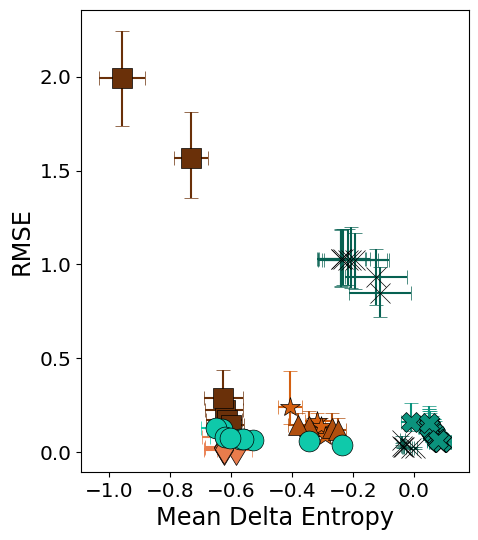

In [6]:
def plot_pareto(df, network, marker):
    for i in range(len(pareto_front[network])):
        x = df[df['optuna_trial_number']==pareto_front[network][i]]['mean_delta_entropy']
        y = df[df['optuna_trial_number']==pareto_front[network][i]]['rmse_peak']
        if i == 0:            
            plt.errorbar(x, y, 
                         xerr=np.asarray(df[df['optuna_trial_number']==pareto_front[network][i]]['entropy_cis'])[0].T, 
                         yerr=np.asarray(df[df['optuna_trial_number']==pareto_front[network][i]]['rmse_cis'])[0].T,  
                         fmt=marker, capsize=5, markeredgecolor='black', markeredgewidth=0.5,
                         color=COLOURS[network], label=network, ms=15)
            
        else:
            plt.errorbar(x, y, 
                         xerr=np.asarray(df[df['optuna_trial_number']==pareto_front[network][i]]['entropy_cis'])[0].T, 
                         yerr=np.asarray(df[df['optuna_trial_number']==pareto_front[network][i]]['rmse_cis'])[0].T, 
                         fmt=marker, capsize=5, markeredgecolor='black', markeredgewidth=0.5,
                         color=COLOURS[network], ms=15)
    plt.xlabel('Mean Delta Entropy', fontsize='xx-large')
    plt.xticks(fontsize='x-large')
    plt.ylabel('RMSE', fontsize='xx-large')
    plt.yticks(fontsize='x-large')
    # plt.legend(bbox_to_anchor=(1.0,1.0), fontsize='x-large')
    

plt.figure(figsize=(5,6))

plot_pareto(df_hop, 'Hopfield', 's')
plot_pareto(df_acc, 'Accumulator', '*')
plot_pareto(df_wta, 'WTA', '^')
plot_pareto(df_dnf, 'DNF', 'd')
plot_pareto(df_sa, 'Shallow Attractor', 'x')
plot_pareto(df_sad, 'Shallow Attractor Place', 'X')
plot_pareto(df_da, 'Deep Attractor', 'o')

# plt.savefig('pareto_front.pdf')

We still need to pick out the actual best performing parameters and explore the parameter values. 

First let's pick out the best as the trial with the lowest total across both performance metrics

In [7]:
def get_score(df):
    df['score'] = df['mean_delta_entropy'] + df['rmse_peak']
    df['score'] = df['score'].astype(float)
    return df

df_hop = get_score(df_hop)
df_acc = get_score(df_acc)
df_wta = get_score(df_wta)
df_dnf = get_score(df_dnf)
df_sa = get_score(df_sa)
df_sad = get_score(df_sad)
df_da = get_score(df_da)

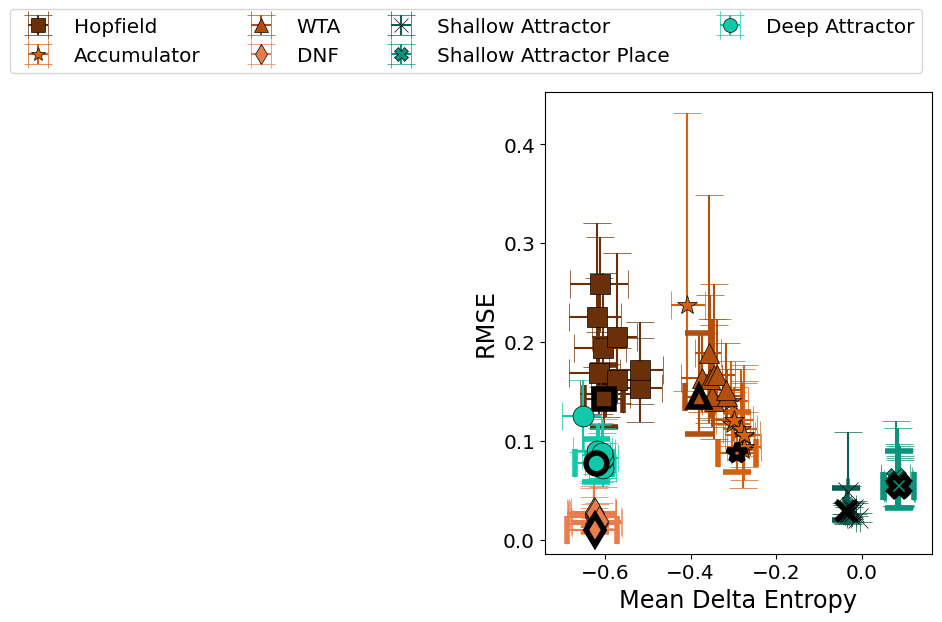

In [ ]:
def plot_best(df, network, marker):
    top_10 = np.argsort(df['score'].values, 0)[:10]

    for i in top_10:

        x = df.iloc[i]['mean_delta_entropy']
        y = df.iloc[i]['rmse_peak']
        if i == top_10[0]:
            plt.errorbar(x,y, 
                         xerr=np.asarray(df.iloc[i]['entropy_cis'])[0].reshape(-1,1), 
                         yerr=np.asarray(df.iloc[i]['rmse_cis'])[0].reshape(-1,1),
                         fmt=marker, ms=10, capsize=10, markeredgecolor='black', markeredgewidth=0.5, color=COLOURS[network], label=network)
        else:
            plt.errorbar(x,y, 
                         xerr=np.asarray(df.iloc[i]['entropy_cis'])[0].reshape(-1,1), 
                         yerr=np.asarray(df.iloc[i]['rmse_cis'])[0].reshape(-1,1),
                         fmt=marker, ms=15, capsize=10, markeredgecolor='black', markeredgewidth=0.5, color=COLOURS[network])
        
    x = df.iloc[top_10[0]]['mean_delta_entropy']
    y = df.iloc[top_10[0]]['rmse_peak']
    plt.errorbar(x,y, 
                 xerr=np.asarray(df.iloc[top_10[0]]['entropy_cis'])[0].reshape(-1,1), 
                 yerr=np.asarray(df.iloc[top_10[0]]['rmse_cis'])[0].reshape(-1,1),
                 fmt=marker, ms=15, capsize=10, markeredgecolor='black', markeredgewidth=4, color=COLOURS[network])

    plt.xlabel('Mean Delta Entropy', fontsize='xx-large')
    plt.xticks(fontsize='x-large')
    plt.ylabel('RMSE', fontsize='xx-large')
    plt.yticks(fontsize='x-large')
    # plt.legend(bbox_to_anchor=(1.0,1.0), fontsize='x-large')
    plt.legend(bbox_to_anchor=(1.0,1.2), ncol=4, fontsize='x-large')
    # plt.legend(fontsize='x-large')

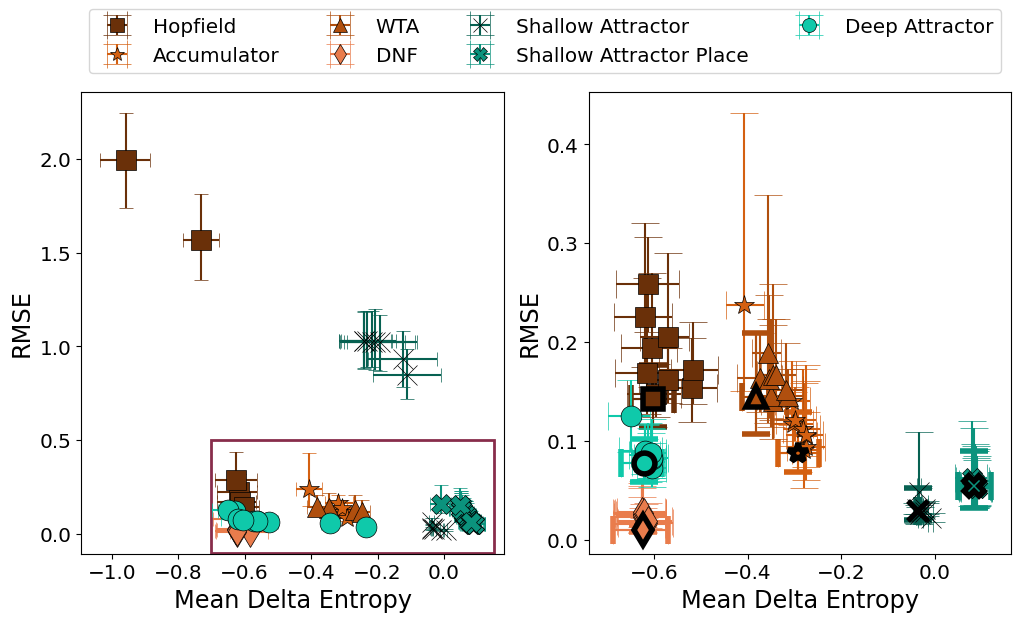

In [28]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)

plot_pareto(df_hop, 'Hopfield', 's')
plot_pareto(df_acc, 'Accumulator', '*')
plot_pareto(df_wta, 'WTA', '^')
plot_pareto(df_dnf, 'DNF', 'd')
plot_pareto(df_sa, 'Shallow Attractor',  'x')
plot_pareto(df_sad, 'Shallow Attractor Place', 'X')
plot_pareto(df_da, 'Deep Attractor', 'o')
ax1.add_patch(Rectangle((-0.7, -0.1), 0.85, 0.6, facecolor="white", edgecolor="#882d4b", linewidth=2.0))

plt.subplot(122)
plot_best(df_hop, 'Hopfield', 's')
plot_best(df_acc, 'Accumulator', '*')
plot_best(df_wta, 'WTA', '^')
plot_best(df_dnf, 'DNF', 'd')
plot_best(df_sa, 'Shallow Attractor', 'x')
plot_best(df_sad, 'Shallow Attractor Place', 'X')
plot_best(df_da, 'Deep Attractor', 'o')

# plt.tight_layout()
plt.savefig('../figs/optimisation_plots.pdf', bbox_inches='tight')

In [10]:
def rmse_target(t: optuna.trial.FrozenTrial) -> float:
    return t.values[0]

def entropy_target(t: optuna.trial.FrozenTrial) -> float:
    return t.values[1]

def explore_params(df, params=[None]):
    
    ## sort values by score and get best 10
    top_10 = np.argsort(df['score'].values, 0)[:10]
    ## print parameter ranges for best performance
    print('Best Parameter Ranges:')
    print(df.iloc[top_10][params].min())
    print(df.iloc[top_10][params].max())
    ## print best parameters
    print('Best Parameter Set:')
    print(df.iloc[top_10[0]][params])
    
    ## create lists of parameters for each parallel coordinate plot
    params_rmse = params + ['rmse_peak']
    params_entropy = params + ['mean_delta_entropy']
    
    ## plot parallel coordinate plot for RMSE peak 
    data = df[params_rmse]
    data = data.values.tolist()
    pcp.plot.pcp(data, params_rmse, alpha=0.8, cmap=plt.get_cmap("Wistia"))
    
    ## plot parallel coordinate plot for entropy score
    data = df[params_entropy]
    data = data.values.tolist()
    pcp.plot.pcp(data, params_entropy, alpha=0.8, cmap=plt.get_cmap("Wistia"))

Best Parameter Ranges:
inp_weight     0.13833500843669647
temp             1.240339928328329
ens_neurons                   1000
dtype: object
inp_weight     0.45349247447155056
temp              9.33842455587437
ens_neurons                   5000
dtype: object
Best Parameter Set:
inp_weight     0.18998077002182454
temp            1.4015715376238007
ens_neurons                   5000
Name: 84, dtype: object


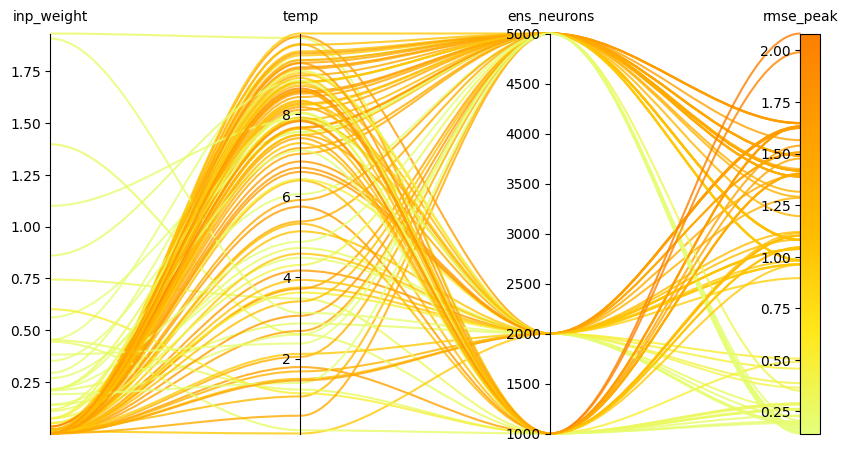

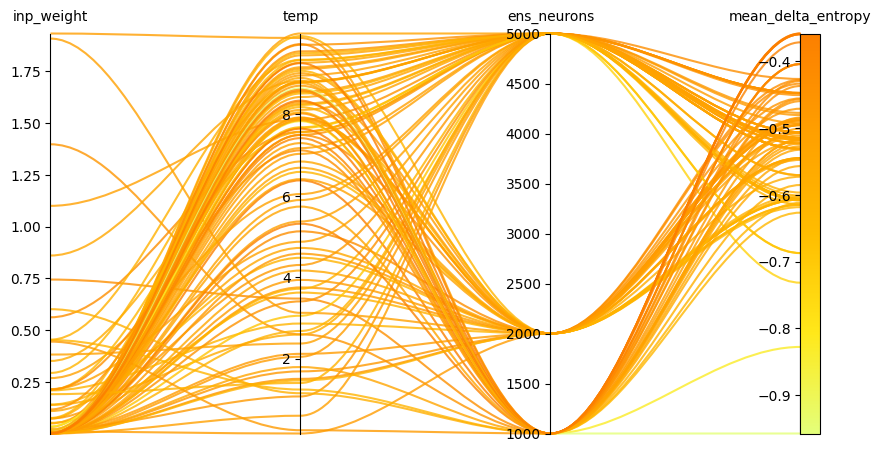

In [11]:
explore_params(df_hop, params=['inp_weight','temp','ens_neurons'])

Best Parameter Ranges:
inp_weight          0.022666784740270934
thresh                0.4936145640816607
intercept_width    0.0021915135877378367
net_neurons                          100
ens_neurons                         1000
dtype: object
inp_weight         0.2669665985957959
thresh             1.3741366215076272
intercept_width    0.9932028817866766
net_neurons                       200
ens_neurons                      2000
dtype: object
Best Parameter Set:
inp_weight         0.022666784740270934
thresh               1.0851625981987953
intercept_width      0.6853614351477068
net_neurons                         100
ens_neurons                        2000
Name: 83, dtype: object


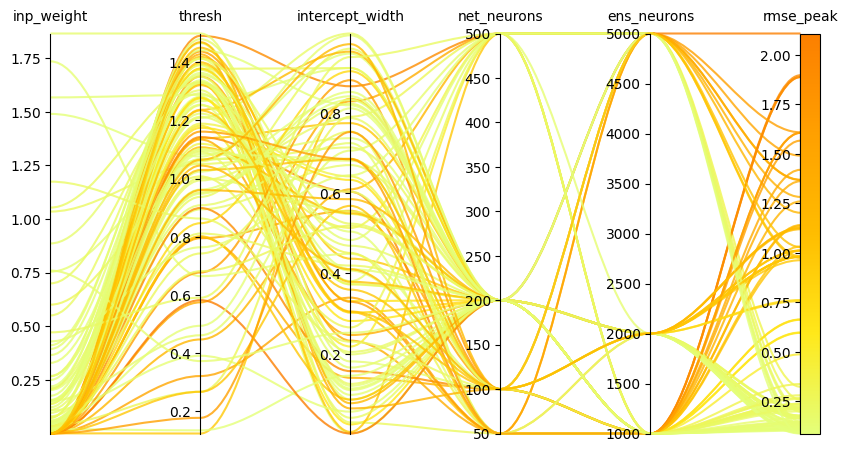

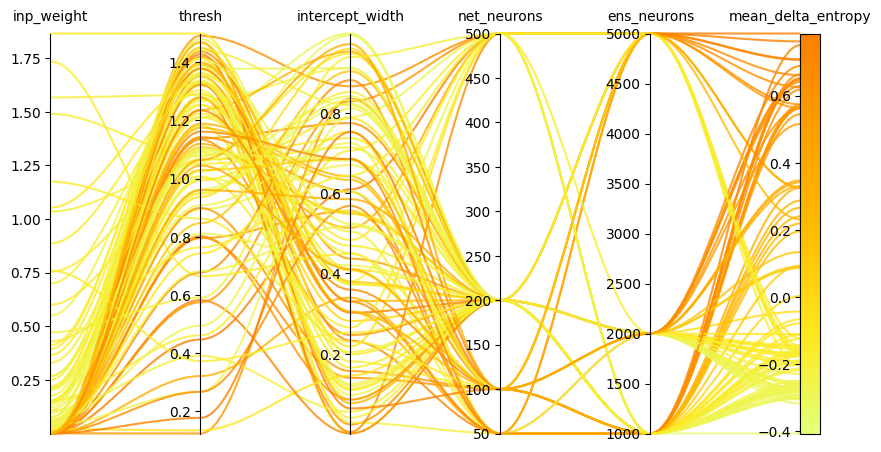

In [12]:
explore_params(df_acc, params=['inp_weight','thresh','intercept_width','net_neurons','ens_neurons'])

Best Parameter Ranges:
inp_weight          0.01336305979838766
thresh              0.19636201058701408
inhib_scale          2.8464602931818654
intercept_width    0.018561985033364592
net_neurons                          50
ens_neurons                        2000
dtype: object
inp_weight         0.6124212038247849
thresh             1.0969952452316702
inhib_scale         4.878850688657879
intercept_width    0.3490242202492281
net_neurons                       500
ens_neurons                      5000
dtype: object
Best Parameter Set:
inp_weight         0.21103640069503118
thresh              1.0223835373930954
inhib_scale         4.3378286766692105
intercept_width    0.03747391773573944
net_neurons                        100
ens_neurons                       5000
Name: 72, dtype: object


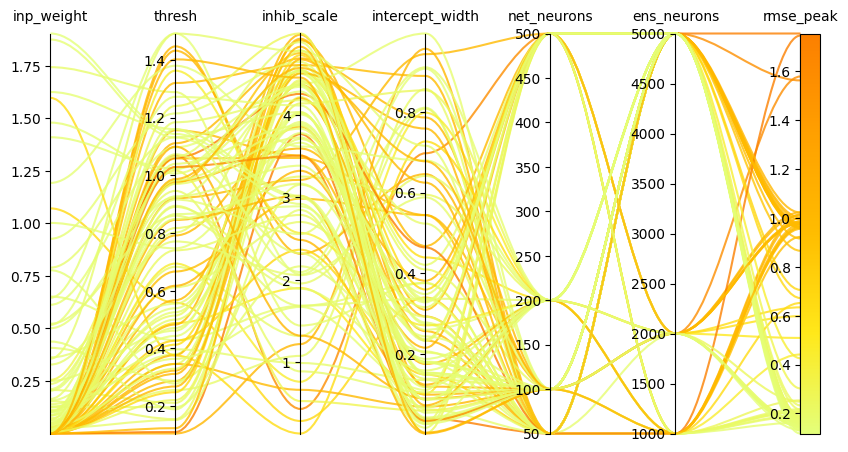

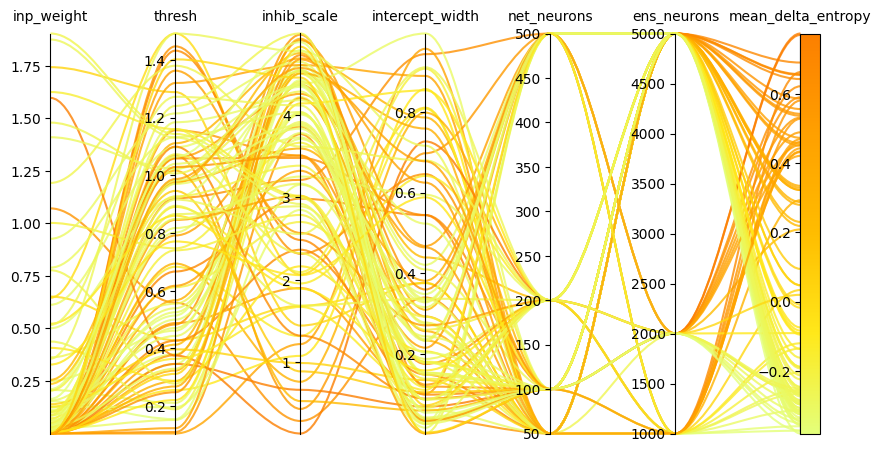

In [13]:
explore_params(df_wta, params=['inp_weight','thresh','inhib_scale','intercept_width','net_neurons','ens_neurons'])

Best Parameter Ranges:
dnf_h                  -19.53795615802421
dnf_global_inhib        6.500171315932708
dnf_tau             0.0032694036639833103
kernel_excit           0.9364297572254348
kernel_inhib           0.4201586216576827
exc_width              1.3511266336964871
inh_width             0.49694094958688745
ens_neurons                          2000
dtype: object
dnf_h               13.829408369061875
dnf_global_inhib    15.102952293911581
dnf_tau             0.1426933054566797
kernel_excit        15.843659387446753
kernel_inhib        17.511090227713066
exc_width            19.03056560493289
inh_width           19.000863275856354
ens_neurons                       5000
dtype: object
Best Parameter Set:
dnf_h                -3.009416816439706
dnf_global_inhib      8.641108231311897
dnf_tau             0.04706404390267922
kernel_excit          9.421285790349613
kernel_inhib         1.4841093480380807
exc_width             8.534993467227224
inh_width             4.748154014869723
e

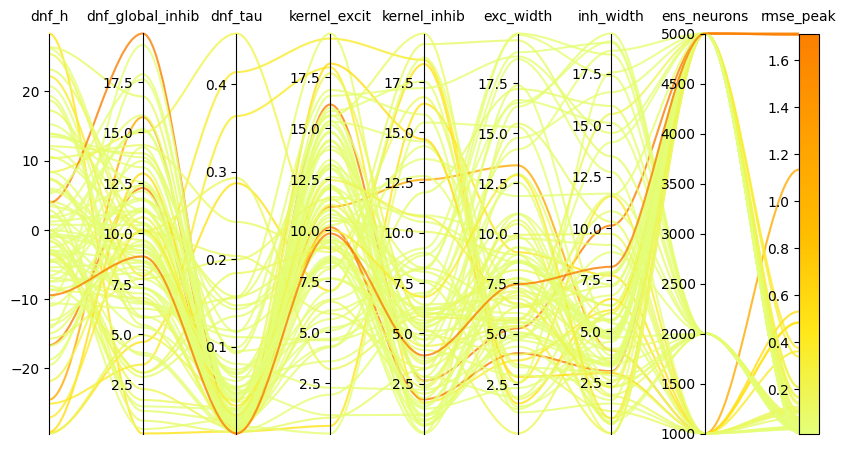

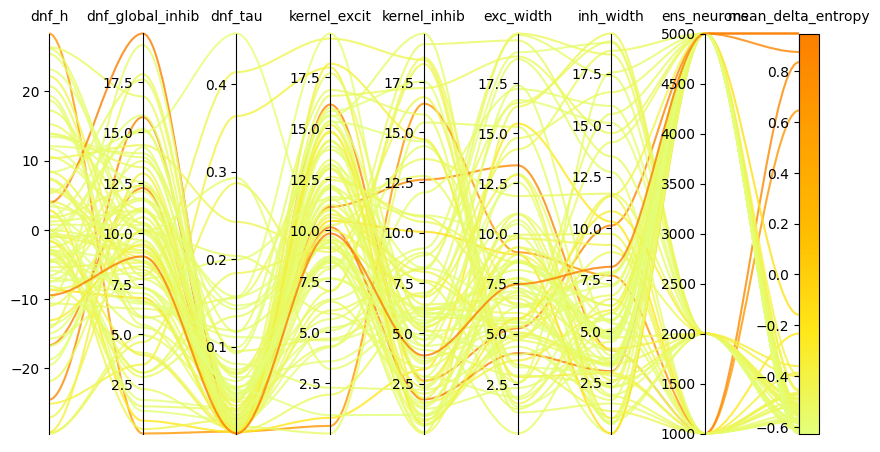

In [14]:
explore_params(df_dnf, params=['dnf_h','dnf_global_inhib','dnf_tau','kernel_excit','kernel_inhib','exc_width','inh_width','ens_neurons'])

Best Parameter Ranges:
inp_weight     0.04889158907582567
ens_neurons                   2000
dtype: object
inp_weight     0.33363837250331163
ens_neurons                   5000
dtype: object
Best Parameter Set:
inp_weight     0.04889158907582567
ens_neurons                   5000
Name: 21, dtype: object


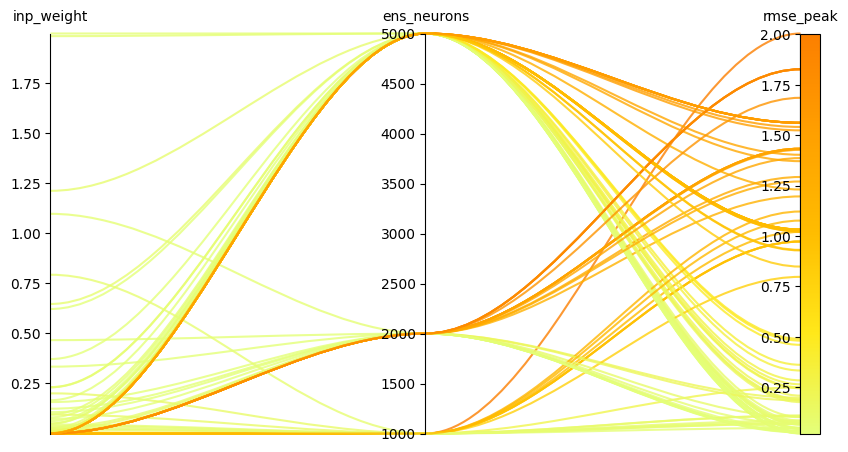

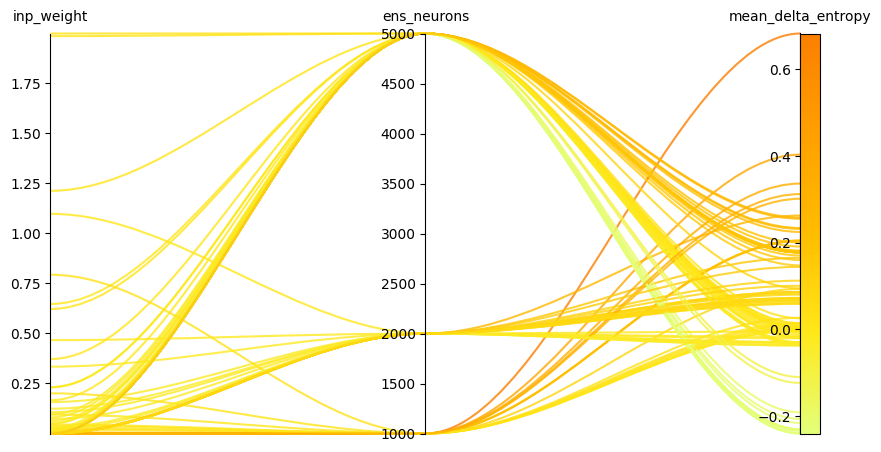

In [15]:
explore_params(df_sa, params=['inp_weight','ens_neurons'])

In [16]:
explore_params(df_sad, params=['inp_weight'])

Best Parameter Ranges:
inp_weight    0.06393950682401134
dtype: object
inp_weight    0.14900665092640128
dtype: object
Best Parameter Set:
inp_weight    0.08389056561408562
Name: 31, dtype: object
Error in callback <function flush_figures at 0x00000177276AB318> (for post_execute):


KeyboardInterrupt: 